In this code  gradient descent and backpropagation to train a neural network on a NSL-KDD dataset.

In [2]:
#Loadig the dataset and displaying the first 5 rows
import pandas as pd
file_path = 'datasetkdd.csv'
df = pd.read_csv(file_path)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


Here we are finding the relevant features using the mutual information and chi-square test this will give two features 
that are most relevant to the target variable.

First section we preprocess the dataset to apply the mutual information and chi-squre test

In [3]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, chi2
import matplotlib.pyplot as plt
import numpy as np

X = df.drop(columns=['class'])
y = df['class']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()
for col in categorical_features:
    X[col] = label_encoder.fit_transform(X[col])

scaler = MinMaxScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# One-hot encode categorical features 
X_categorical = pd.get_dummies(X, drop_first=True)  

# Mutual Information Scores
mi_scores = mutual_info_classif(X, y_encoded, random_state=0)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_scores)

# Chi-Square Test Scores
chi2_scores, p_values = chi2(X_categorical, y_encoded)  # Use one-hot encoded features
chi2_scores = pd.Series(chi2_scores, index=X_categorical.columns).sort_values(ascending=False)
print("\nChi-Square Test Scores:")
print(chi2_scores)

# Combine both MI and Chi-Square scores
combined_scores = mi_scores.add(chi2_scores, fill_value=0)  
combined_scores = combined_scores.sort_values(ascending=False)

top_featuress = combined_scores.index[:2]
print("\nTop 18 features based on combined Mutual Information and Chi-Square scores:")
print(top_featuress)

X_top_18 = X[top_featuress]

plt.figure(figsize=(10, 8))
corr_matrix = X_top_18.corr()
#plt.title("Correlation Matrix - Top 18 Features")
plt.show()
threshold = 0.9
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Final selected features after removing correlated ones
final_selected_features = top_featuress.drop(to_drop)
print("\nFinal selected features after removing correlated ones:")
print(final_selected_features)

# List of features selected for training
selected_list = final_selected_features.tolist()
print("\nFeatures selected for training:")
print(selected_list)

# Print Chi-Square scores for the final selected features
final_chi2_scores = chi2_scores[final_selected_features]
print("\nChi-Square scores for the final selected features:")
print(final_chi2_scores)



Mutual Information Scores:
src_bytes                      0.542678
dst_bytes                      0.437492
service                        0.434002
flag                           0.338065
same_srv_rate                  0.328913
diff_srv_rate                  0.320513
dst_host_srv_count             0.302225
dst_host_same_srv_rate         0.278945
logged_in                      0.264642
dst_host_diff_srv_rate         0.259576
dst_host_serror_rate           0.239895
serror_rate                    0.235771
count                          0.234296
dst_host_srv_serror_rate       0.232838
srv_serror_rate                0.223356
dst_host_srv_diff_host_rate    0.173179
dst_host_count                 0.137067
dst_host_same_src_port_rate    0.129467
srv_diff_host_rate             0.098674
dst_host_srv_rerror_rate       0.064341
rerror_rate                    0.055661
protocol_type                  0.054081
dst_host_rerror_rate           0.052164
srv_rerror_rate                0.052009
srv_count   

<Figure size 1000x800 with 0 Axes>


Final selected features after removing correlated ones:
Index(['service', 'flag'], dtype='object')

Features selected for training:
['service', 'flag']

Chi-Square scores for the final selected features:
service    111750.974116
flag        65087.683360
dtype: float64


Selected two features from above test and select those features for model testing and training

In [4]:
selected_features = ['service', 'flag']

X = df[selected_features].copy()
y = df['class'].apply(lambda x: 1 if x == 'anomaly' else 0) 

label_encoder = LabelEncoder()
X['flag'] = label_encoder.fit_transform(X['flag'])
X['service'] = label_encoder.fit_transform(X['service'])
X['class'] = y
print("\n after preprocessing")
X.head() 


 after preprocessing


,service,flag,class
0,20,9,0
1,44,9,0
2,49,5,1
3,24,9,0
4,24,9,0


Spliting the model into 70% training and 30% for testing 

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='class'), y, test_size=0.3, random_state=42)


The below code demonstrates using  StandardScaler standardize features in the dataset. It transforms the training data and returns the scaled data back into DataFrames it will help for easier analysis.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nScaled training features:")
X_train_scaled.head()


Scaled training features:


,service,flag
0,1.371046,0.734785
1,0.142434,-0.704337
2,-0.471872,0.734785
3,-0.471872,0.734785
4,-0.471872,0.734785


This code defines a feedforward neural network model using TensorFlow and Keras libraries. The model consists of three layers an input layer, two hidden layers and  output layer. It uses ReLU activation function,sigmoid activation function a stochastic gradient descent optimizer to minimize binary crossentropy loss.

In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_model(input_shape):
    model = keras.Sequential()
    
    # Input layer and first hidden layer
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    
    # Second hidden layer
    model.add(layers.Dense(32, activation='relu'))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))  
    
    return model

input_shape = (X_train_scaled.shape[1],) 
model = create_model(input_shape)

# Compile
model.compile(optimizer='sgd',              # Stochastic Gradient Descent
              loss='binary_crossentropy',  
              metrics=['accuracy'])        


This code will create two plots one for the models loss over time and one for the models accuracy over time. The plots will show the training and validation loss and accuracy.

In [58]:
history = model.fit(X_train_scaled, y_train, 
                    validation_split=0.2,  
                    epochs=50,            
                    batch_size=128,         
                    verbose=1)            


Epoch 1/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8327 - loss: 0.5765 - val_accuracy: 0.8568 - val_loss: 0.4076
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8562 - loss: 0.3995 - val_accuracy: 0.8567 - val_loss: 0.3788
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8575 - loss: 0.3742 - val_accuracy: 0.8568 - val_loss: 0.3629
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8570 - loss: 0.3593 - val_accuracy: 0.8563 - val_loss: 0.3494
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8573 - loss: 0.3440 - val_accuracy: 0.8544 - val_loss: 0.3386
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8578 - loss: 0.3302 - val_accuracy: 0.8544 - val_loss: 0.3312
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8559 - loss: 0.3272 - val_accuracy: 0.8544 - val_loss: 0.3251
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8558 - loss: 0.3215 - val_accuracy: 0.

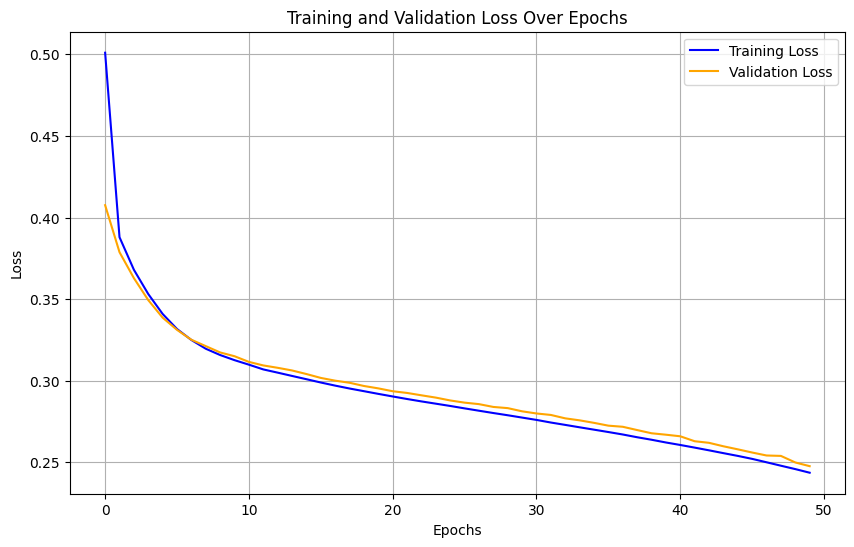

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


For better result we use another to check models accuracy over time to identify issues such as overfitting or underfitting. By analyzing the plots of accuracy and loss one can make informed decisions about further training adjustments to model architecture or tuning hyperparameters.

In [60]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

# Model setup (assuming model is already defined)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model training parameters
epochs = 10  
batch_size = 32  

# Train the model
history = model.fit(X_train_scaled, y_train, 
                    validation_split=0.1,  
                    epochs=epochs,         
                    batch_size=batch_size,  
                    verbose=1, 
                    callbacks=[early_stopping])




Epoch 1/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9170 - loss: 0.2405 - val_accuracy: 0.9178 - val_loss: 0.2423
Epoch 2/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9218 - loss: 0.2297 - val_accuracy: 0.9321 - val_loss: 0.2335
Epoch 3/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9254 - loss: 0.2226 - val_accuracy: 0.9178 - val_loss: 0.2238
Epoch 4/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9277 - loss: 0.2147 - val_accuracy: 0.9140 - val_loss: 0.2182
Epoch 5/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9268 - loss: 0.2105 - val_accuracy: 0.9286 - val_loss: 0.2170
Epoch 6/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9284 - loss: 0.2054 - val_accuracy: 0.9182 - val_loss: 0.2111
Epoch 7/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9308 - loss: 0.2004 - val_accuracy: 0.9288 - val_loss: 0.2038
Epoch 8/10
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9298 - loss: 0.1980 - 

Visualize the learning process by plotting the model's training and validation loss against epochs and the decision boundary using Matplotlib, observing trends and interpreting model performance, especially when using two features.

In [52]:
# two features 
feature_1 = 'service'  
feature_2 = 'flag'     
X_vis = X[[feature_1, feature_2]].copy() #dataframe with 2 feaautres


266250/266250 ━━━━━━━━━━━━━━━━━━━━ 202s 759us/step


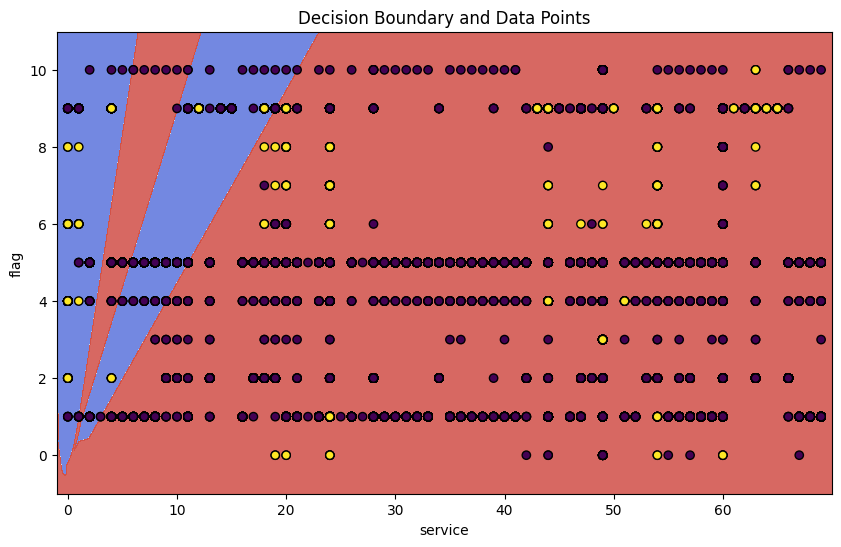

In [25]:
import numpy as np

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_vis[feature_1].min() - 1, X_vis[feature_1].max() + 1
y_min, y_max = X_vis[feature_2].min() - 1, X_vis[feature_2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])  
Z = (Z > 0.5).astype(int)  
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_vis[feature_1], X_vis[feature_2], c=y_encoded, edgecolors='k', marker='o')
plt.title('Decision Boundary and Data Points')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.show()


In [53]:
# Evaluate the model 
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Test Loss: 0.19139492511749268
Test Accuracy: 0.9283598065376282


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


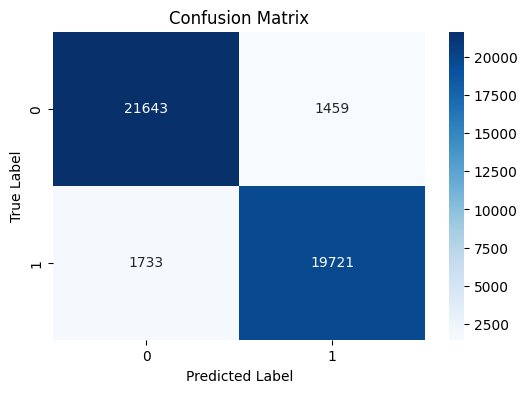

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)  

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [55]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'])
print("\nClassification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.94      0.93     23102
   Malicious       0.93      0.92      0.93     21454

    accuracy                           0.93     44556
   macro avg       0.93      0.93      0.93     44556
weighted avg       0.93      0.93      0.93     44556



In [31]:
from tensorflow.keras.optimizers import SGD

def create_model_with_lr(input_shape, learning_rate):
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) 
    optimizer = SGD(learning_rate=learning_rate)  
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

learning_rates = [0.001, 0.01, 0.1, 0.5]

# Loop learning rate, train and evaluate the model
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = create_model_with_lr(input_shape, learning_rate=lr)
    history = model.fit(X_train_scaled, y_train, 
                        validation_split=0.2, 
                        epochs=10, 
                        batch_size=32, 
                        verbose=1)
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy with learning rate {lr}: {test_accuracy}")



Training with learning rate: 0.001
Epoch 1/10


c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2599/2599 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7455 - loss: 0.6242 - val_accuracy: 0.8568 - val_loss: 0.4931
Epoch 2/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8570 - loss: 0.4665 - val_accuracy: 0.8568 - val_loss: 0.4160
Epoch 3/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8578 - loss: 0.4088 - val_accuracy: 0.8560 - val_loss: 0.3950
Epoch 4/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8578 - loss: 0.3918 - val_accuracy: 0.8560 - val_loss: 0.3863
Epoch 5/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8582 - loss: 0.3818 - val_accuracy: 0.8560 - val_loss: 0.3802
Epoch 6/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8589 - loss: 0.3761 - val_accuracy: 0.8560 - val_loss: 0.3746
Epoch 7/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8590 - loss: 0.3698 - val_accuracy: 0.8560 - val_loss: 0.3693
Epoch 8/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8575 - loss: 0.3666 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2599/2599 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8267 - loss: 0.4545 - val_accuracy: 0.8566 - val_loss: 0.3481
Epoch 2/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8582 - loss: 0.3333 - val_accuracy: 0.8544 - val_loss: 0.3186
Epoch 3/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8629 - loss: 0.3112 - val_accuracy: 0.8693 - val_loss: 0.3065
Epoch 4/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8698 - loss: 0.3022 - val_accuracy: 0.8689 - val_loss: 0.2985
Epoch 5/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8730 - loss: 0.2904 - val_accuracy: 0.8680 - val_loss: 0.2940
Epoch 6/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8725 - loss: 0.2846 - val_accuracy: 0.8692 - val_loss: 0.2868
Epoch 7/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8697 - loss: 0.2824 - val_accuracy: 0.8677 - val_loss: 0.2828
Epoch 8/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8694 - loss: 0.2768 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2599/2599 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8521 - loss: 0.3589 - val_accuracy: 0.8569 - val_loss: 0.2919
Epoch 2/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8857 - loss: 0.2740 - val_accuracy: 0.9007 - val_loss: 0.2492
Epoch 3/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9136 - loss: 0.2287 - val_accuracy: 0.9193 - val_loss: 0.2291
Epoch 4/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9234 - loss: 0.2056 - val_accuracy: 0.9218 - val_loss: 0.1962
Epoch 5/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9268 - loss: 0.1975 - val_accuracy: 0.9170 - val_loss: 0.1958
Epoch 6/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9299 - loss: 0.1907 - val_accuracy: 0.9315 - val_loss: 0.1945
Epoch 7/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9303 - loss: 0.1913 - val_accuracy: 0.9255 - val_loss: 0.1914
Epoch 8/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9323 - loss: 0.1863 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8594 - loss: 0.3242 - val_accuracy: 0.9157 - val_loss: 0.2483
Epoch 2/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9036 - loss: 0.2445 - val_accuracy: 0.8717 - val_loss: 0.2849
Epoch 3/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8707 - loss: 0.2782 - val_accuracy: 0.8899 - val_loss: 0.2416
Epoch 4/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8874 - loss: 0.2603 - val_accuracy: 0.9107 - val_loss: 0.2680
Epoch 5/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9051 - loss: 0.2340 - val_accuracy: 0.9222 - val_loss: 0.2091
Epoch 6/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9246 - loss: 0.1988 - val_accuracy: 0.9206 - val_loss: 0.2042
Epoch 7/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9264 - loss: 0.1936 - val_accuracy: 0.9183 - val_loss: 0.1975
Epoch 8/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9273 - loss: 0.1939 - val_accurac

In [32]:
def create_model_with_optimizer(input_shape, optimizer_name):
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam()
    elif optimizer_name == 'rmsprop':
        optimizer = keras.optimizers.RMSprop()
    else:
        optimizer = keras.optimizers.SGD()  
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

optimizers = ['sgd', 'adam', 'rmsprop']
for opt in optimizers:
    print(f"\nTraining with optimizer: {opt}")
    model = create_model_with_optimizer(input_shape, optimizer_name=opt)
    history = model.fit(X_train_scaled, y_train, 
                        validation_split=0.2, 
                        epochs=10, 
                        batch_size=32, 
                        verbose=1)
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy with optimizer {opt}: {test_accuracy}")



Training with optimizer: sgd
Epoch 1/10


c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2599/2599 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8009 - loss: 0.4839 - val_accuracy: 0.8563 - val_loss: 0.3582
Epoch 2/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8557 - loss: 0.3451 - val_accuracy: 0.8544 - val_loss: 0.3258
Epoch 3/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8570 - loss: 0.3192 - val_accuracy: 0.8693 - val_loss: 0.3151
Epoch 4/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8721 - loss: 0.3086 - val_accuracy: 0.8693 - val_loss: 0.3063
Epoch 5/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8736 - loss: 0.2965 - val_accuracy: 0.8683 - val_loss: 0.2999
Epoch 6/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8684 - loss: 0.2976 - val_accuracy: 0.8688 - val_loss: 0.2946
Epoch 7/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8712 - loss: 0.2868 - val_accuracy: 0.8687 - val_loss: 0.2891
Epoch 8/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8712 - loss: 0.2803 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2599/2599 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8579 - loss: 0.3544 - val_accuracy: 0.8685 - val_loss: 0.2859
Epoch 2/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8750 - loss: 0.2743 - val_accuracy: 0.9178 - val_loss: 0.2679
Epoch 3/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9008 - loss: 0.2555 - val_accuracy: 0.9207 - val_loss: 0.2332
Epoch 4/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9254 - loss: 0.2220 - val_accuracy: 0.9224 - val_loss: 0.2131
Epoch 5/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9298 - loss: 0.2005 - val_accuracy: 0.9294 - val_loss: 0.2013
Epoch 6/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9305 - loss: 0.1929 - val_accuracy: 0.9294 - val_loss: 0.1883
Epoch 7/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9332 - loss: 0.1831 - val_accuracy: 0.9387 - val_loss: 0.1821
Epoch 8/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9319 - loss: 0.1859 - val_accurac

c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2599/2599 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8536 - loss: 0.3523 - val_accuracy: 0.8693 - val_loss: 0.2825
Epoch 2/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8819 - loss: 0.2664 - val_accuracy: 0.8874 - val_loss: 0.2482
Epoch 3/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9206 - loss: 0.2296 - val_accuracy: 0.9272 - val_loss: 0.2176
Epoch 4/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9331 - loss: 0.1989 - val_accuracy: 0.9270 - val_loss: 0.2034
Epoch 5/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9330 - loss: 0.1915 - val_accuracy: 0.9335 - val_loss: 0.1943
Epoch 6/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9328 - loss: 0.1891 - val_accuracy: 0.9369 - val_loss: 0.1959
Epoch 7/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9352 - loss: 0.1801 - val_accuracy: 0.9300 - val_loss: 0.1922
Epoch 8/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9324 - loss: 0.1866 - val_accurac

In [33]:
def create_model_with_extra_layer(input_shape):
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu')) 
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam() 
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

print("\nTraining with an extra hidden layer")
model = create_model_with_extra_layer(input_shape)
history = model.fit(X_train_scaled, y_train, 
                    validation_split=0.2, 
                    epochs=10, 
                    batch_size=32, 
                    verbose=1)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy with extra hidden layer: {test_accuracy}")




Training with an extra hidden layer
Epoch 1/10


c:\Users\civin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2599/2599 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8588 - loss: 0.3380 - val_accuracy: 0.8360 - val_loss: 0.2813
Epoch 2/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9174 - loss: 0.2352 - val_accuracy: 0.9325 - val_loss: 0.1958
Epoch 3/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9327 - loss: 0.1881 - val_accuracy: 0.9342 - val_loss: 0.1863
Epoch 4/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9343 - loss: 0.1792 - val_accuracy: 0.9337 - val_loss: 0.1826
Epoch 5/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9356 - loss: 0.1767 - val_accuracy: 0.9358 - val_loss: 0.1767
Epoch 6/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9351 - loss: 0.1771 - val_accuracy: 0.9334 - val_loss: 0.1829
Epoch 7/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9339 - loss: 0.1782 - val_accuracy: 0.9357 - val_loss: 0.1789
Epoch 8/10
2599/2599 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9350 - loss: 0.1779 - val_accurac